# 2d slices of brain tumor Decathlon for image regression

Create a new dataset from the 3d brain tumor decathlon data.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd, T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

From the training images, take slice which contains most segmentation classes > 0. This will be roughly around the center of the tumor. Also take the 5 slices on either side.

From the test images, take the center image, plus the 5 slices on either side.

Combine these together to make a new dataset. The input images will be the FLAIR, T1w and T2w images. The output will be the T1gd images.

This dataset can then be used for experimenting with image regression, generating T1gd images from other MR modalities.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.7.0rc3+7.g3a597cfb
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 3a597cfbd2b022a10b20470f596c03028371c5a6

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu102
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
root_dir = os.environ.get("MONAI_DATA_DIRECTORY")
assert root_dir is not None
print(root_dir)

/home/rich/Documents/Data/MONAI


In [4]:
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
])
test_transforms =  Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys="image"),
])

In [5]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=transforms,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=10,
    val_frac=0,
)
test_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=test_transforms,
    section="test",
    download=True,
    cache_rate=0.0,
    num_workers=10,
    val_frac=0,
)

Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
File exists: /home/rich/Documents/Data/MONAI/Task01_BrainTumour.tar, skipped downloading.
Non-empty folder exists in /home/rich/Documents/Data/MONAI/Task01_BrainTumour, skipped extracting.
Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
File exists: /home/rich/Documents/Data/MONAI/Task01_BrainTumour.tar, skipped downloading.
Non-empty folder exists in /home/rich/Documents/Data/MONAI/Task01_BrainTumour, skipped extracting.


In [6]:
train_ds[0]["image"].shape, train_ds[0]["label"].shape, np.unique(train_ds[0]["label"])

((4, 240, 240, 155), (240, 240, 155), array([0., 1., 2., 3.], dtype=float32))

## Check data shape and visualize

image shape: (4, 240, 240, 155)


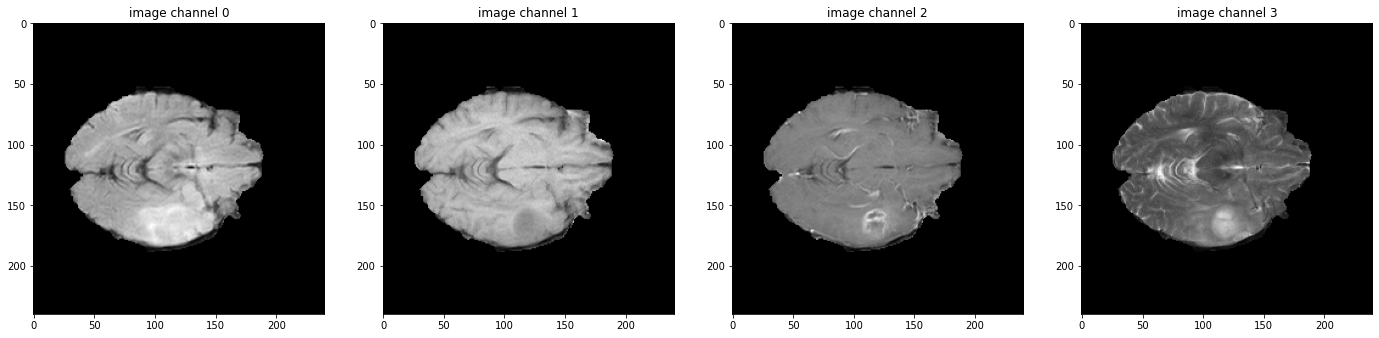

In [7]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {train_ds[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(train_ds[2]["image"][i, :, :, 60], cmap="gray")
plt.show()

In [9]:
def split_input_output(im, output_slice):
    im_output = im[output_slice][None]
    im_input = np.delete(im, output_slice, axis=0)
    return im_input, im_output

out_dir = os.path.join(root_dir, "brain_2d")
os.makedirs(out_dir)
counter = 0
for data in tqdm(train_ds):
    image, label = data["image"], data["label"]
    z_slices = label.shape[-1]
    bin_label = label > 0
    flat_label = bin_label.reshape(-1, z_slices)
    z_slice_counts = flat_label.sum(axis=0)
    location = np.where(z_slice_counts == z_slice_counts.max())[0][0]
    for i in range(-5, 5):
        im = image[...,location + i]
        im_input, im_output = split_input_output(im, output_slice=3)
        im_input = np.delete(im, 2, axis=0)
        np.save(os.path.join(out_dir, str(counter) + "_GT_output"), im_output)
        np.save(os.path.join(out_dir, str(counter) + "_input"), im_input)
        counter += 1

100%|██████████| 484/484 [04:03<00:00,  1.99it/s]


In [10]:
for data in tqdm(test_ds):
    image = data["image"]
    z_slice = image.shape[-1] // 2
    for i in range(-5, 5):
        im = image[..., z_slice + i]
        im_input, im_output = split_input_output(im, output_slice=3)
        np.save(os.path.join(out_dir, str(counter) + "_GT_output"), im_output)
        np.save(os.path.join(out_dir, str(counter) + "_input"), im_input)
        counter += 1

100%|██████████| 266/266 [02:02<00:00,  2.18it/s]
